In [4]:
from tools.propagate import assign_detectors_to_grid, create_detector_grid_map, create_inverted_detector_map, calculate_grid_centers, find_closest_detectors
from tools.geometry import generate_detector
import jax
import jax.numpy as jnp
import numpy as np
from scipy.spatial.distance import pdist

jax.config.update('jax_platform_name', 'cpu')

In [5]:
json_filename = 'config/cyl_geom_config.json'
detector = generate_detector(json_filename)

detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius

detector_cases = np.array([detector.ID_to_case[i] for i in range(len(detector.all_points))])

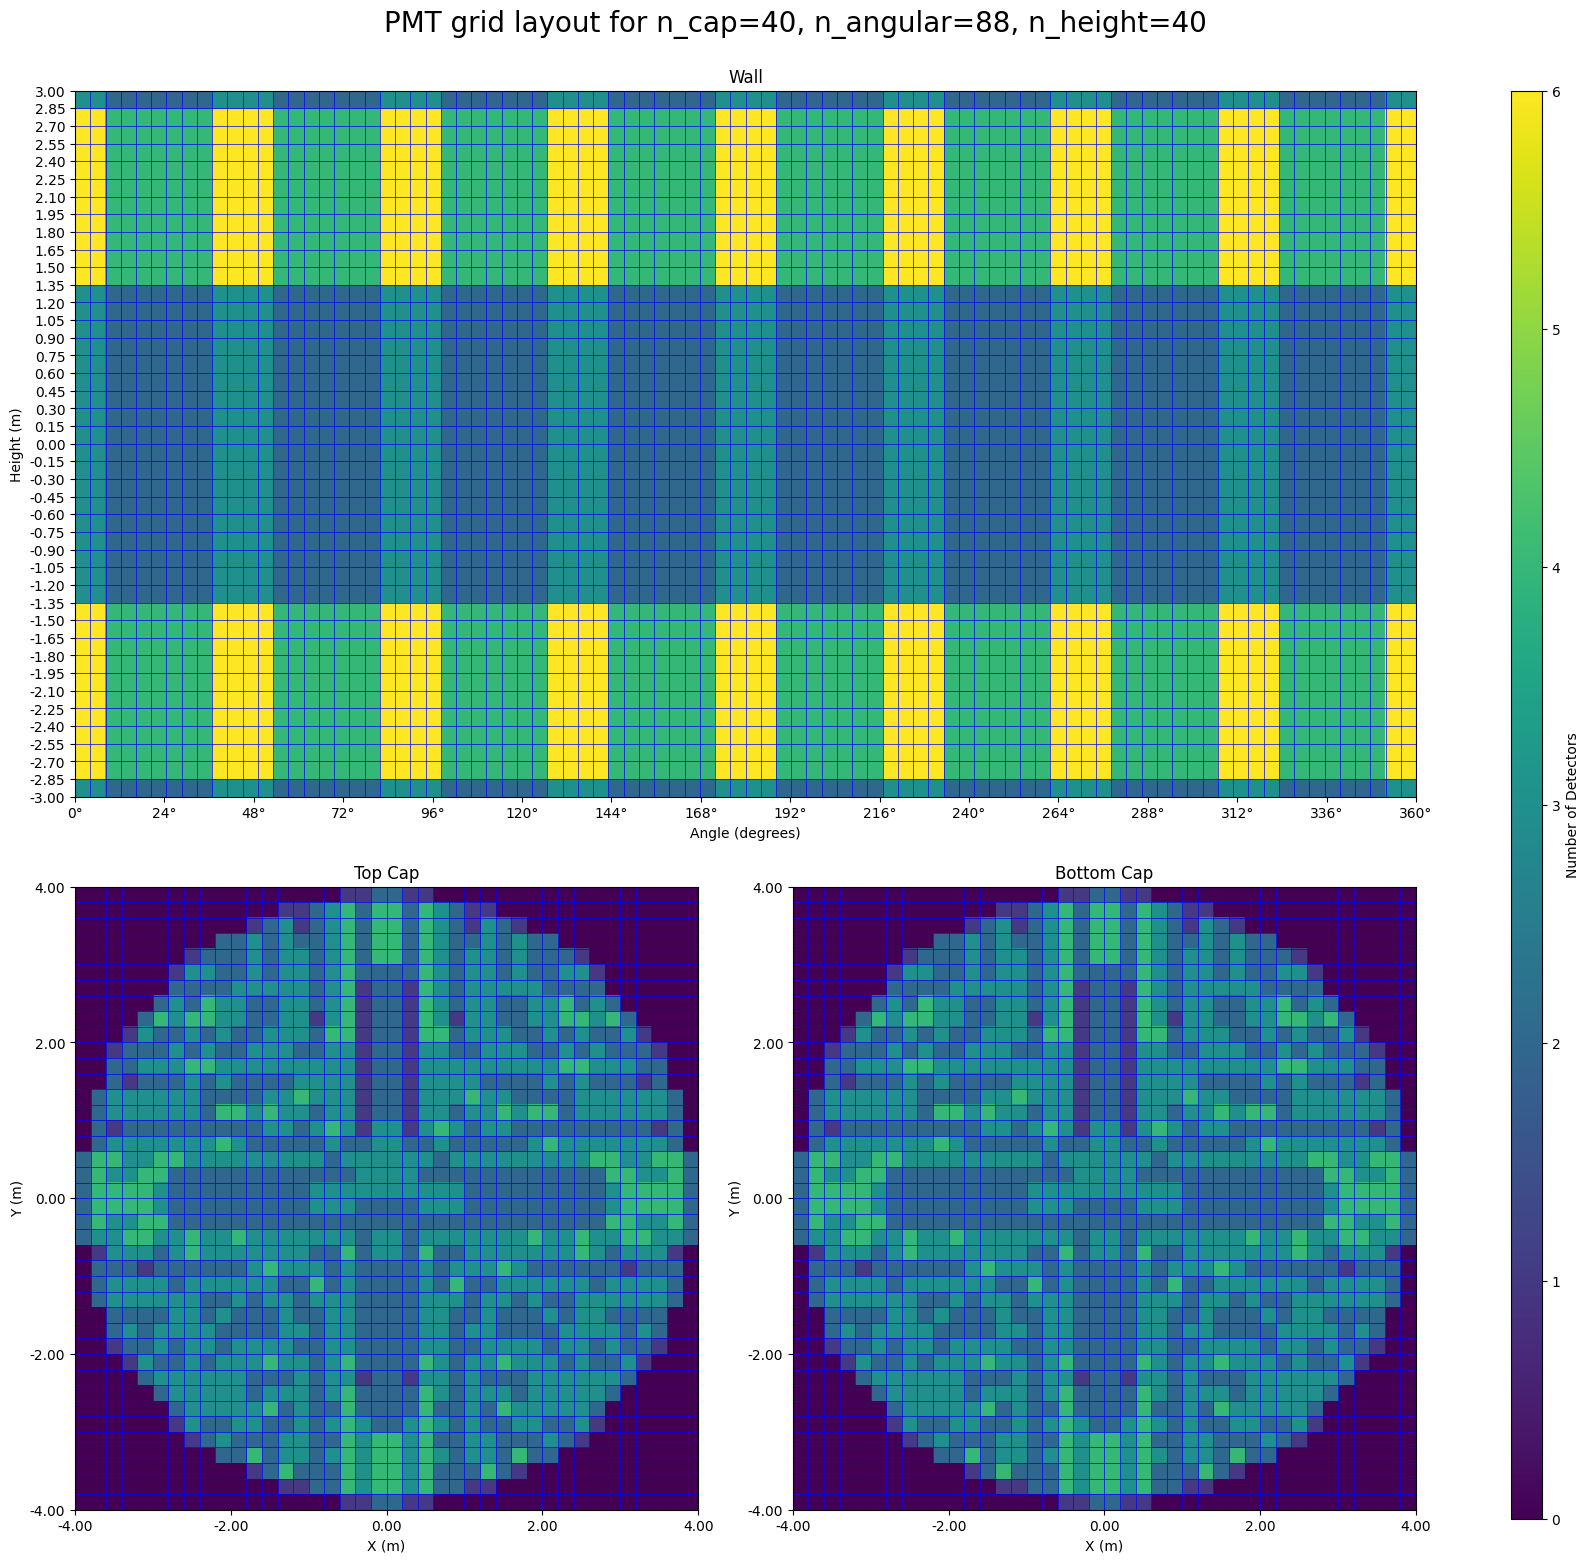

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_detector_grid(detector_grid_map, r, h, n_cap, n_angular, n_height):
    wall_data = detector_grid_map[:n_angular * n_height].reshape(n_angular, n_height)
    cap_data = detector_grid_map[n_angular * n_height:].reshape(2, n_cap, n_cap)

    fig = plt.figure(figsize=(16, 16))

    # Create a grid for subplots with adjusted ratios
    gs = fig.add_gridspec(2, 3, height_ratios=[1.1, 1], width_ratios=[1, 1, 0.05])

    # Plot wall (top subplot)
    ax_wall = fig.add_subplot(gs[0, :2])
    global_max = np.max(detector_grid_map)
    extent = [0, 360, -h/2, h/2]
    im1 = ax_wall.imshow(wall_data.T, aspect='auto', origin='lower', interpolation='nearest', 
                         extent=extent, vmin=0, vmax=global_max, cmap='viridis')
    ax_wall.set_title('Wall')
    ax_wall.set_xlabel('Angle (degrees)')
    ax_wall.set_ylabel('Height (m)')

    angle_step = 360 / n_angular
    height_step = h / n_height

    for angle in np.arange(0, 360 + angle_step, angle_step):
        ax_wall.axvline(x=angle, color='b', linestyle='-', linewidth=0.5)

    for height in np.arange(-h/2, h/2 + height_step, height_step):
        ax_wall.axhline(y=height, color='b', linestyle='-', linewidth=0.5)

    major_ticks = np.arange(0, 361, max(1, int(angle_step * 6)))
    ax_wall.set_xticks(major_ticks)
    ax_wall.set_xticklabels([f"{x}°" for x in major_ticks])

    y_ticks = np.linspace(-h/2, h/2, n_height + 1)
    ax_wall.set_yticks(y_ticks)
    ax_wall.set_yticklabels([f"{y:.2f}" for y in y_ticks])

    ax_wall.set_ylim(-h/2, h/2)

    # Function to format cap plots
    def format_cap_plot(ax, data, title):
        im = ax.imshow(data, cmap='viridis', vmin=0, vmax=global_max, origin='lower', extent=[-r, r, -r, r])
        ax.set_title(title)
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        
        # Add grid lines
        grid_step = 2 * r / n_cap
        for i in range(n_cap + 1):
            ax.axhline(y=-r + i * grid_step, color='b', linestyle='-', linewidth=0.5)
            ax.axvline(x=-r + i * grid_step, color='b', linestyle='-', linewidth=0.5)
        
        # Set ticks
        ticks = np.linspace(-r, r, 5)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels([f"{x:.2f}" for x in ticks])
        ax.set_yticklabels([f"{y:.2f}" for y in ticks])
        
        return im

    # Plot top cap (bottom left subplot)
    ax_top = fig.add_subplot(gs[1, 0])
    im2 = format_cap_plot(ax_top, cap_data[0], 'Top Cap')

    # Plot bottom cap (bottom right subplot)
    ax_bottom = fig.add_subplot(gs[1, 1])
    im3 = format_cap_plot(ax_bottom, cap_data[1], 'Bottom Cap')

    # Add a single colorbar on the right
    cax = fig.add_subplot(gs[:, -1])
    cbar = plt.colorbar(im1, cax=cax, label='Number of Detectors')
    
    # Set integer ticks on the colorbar
    cbar.set_ticks(np.arange(0, global_max + 1, max(1, int(global_max / 10))))
    cbar.set_ticklabels([str(int(tick)) for tick in cbar.get_ticks()])

    fig.suptitle(f"PMT grid layout for {n_cap=}, {n_angular=}, {n_height=}", fontsize=20)

    plt.tight_layout(rect=[0, 0.0, 1, 0.98])
    plt.show()

# Example usage
r, h = 4.0, 6.0
n_cap, n_angular, n_height = 40, 88, 40

assignments = assign_detectors_to_grid(detector_points, detector_radius, r, h, n_cap, n_angular, n_height)
detector_grid_map = create_detector_grid_map(assignments, n_cap, n_angular, n_height)

# Assuming you have detector_grid_map from previous computations
plot_detector_grid(detector_grid_map, r, h, n_cap, n_angular, n_height)

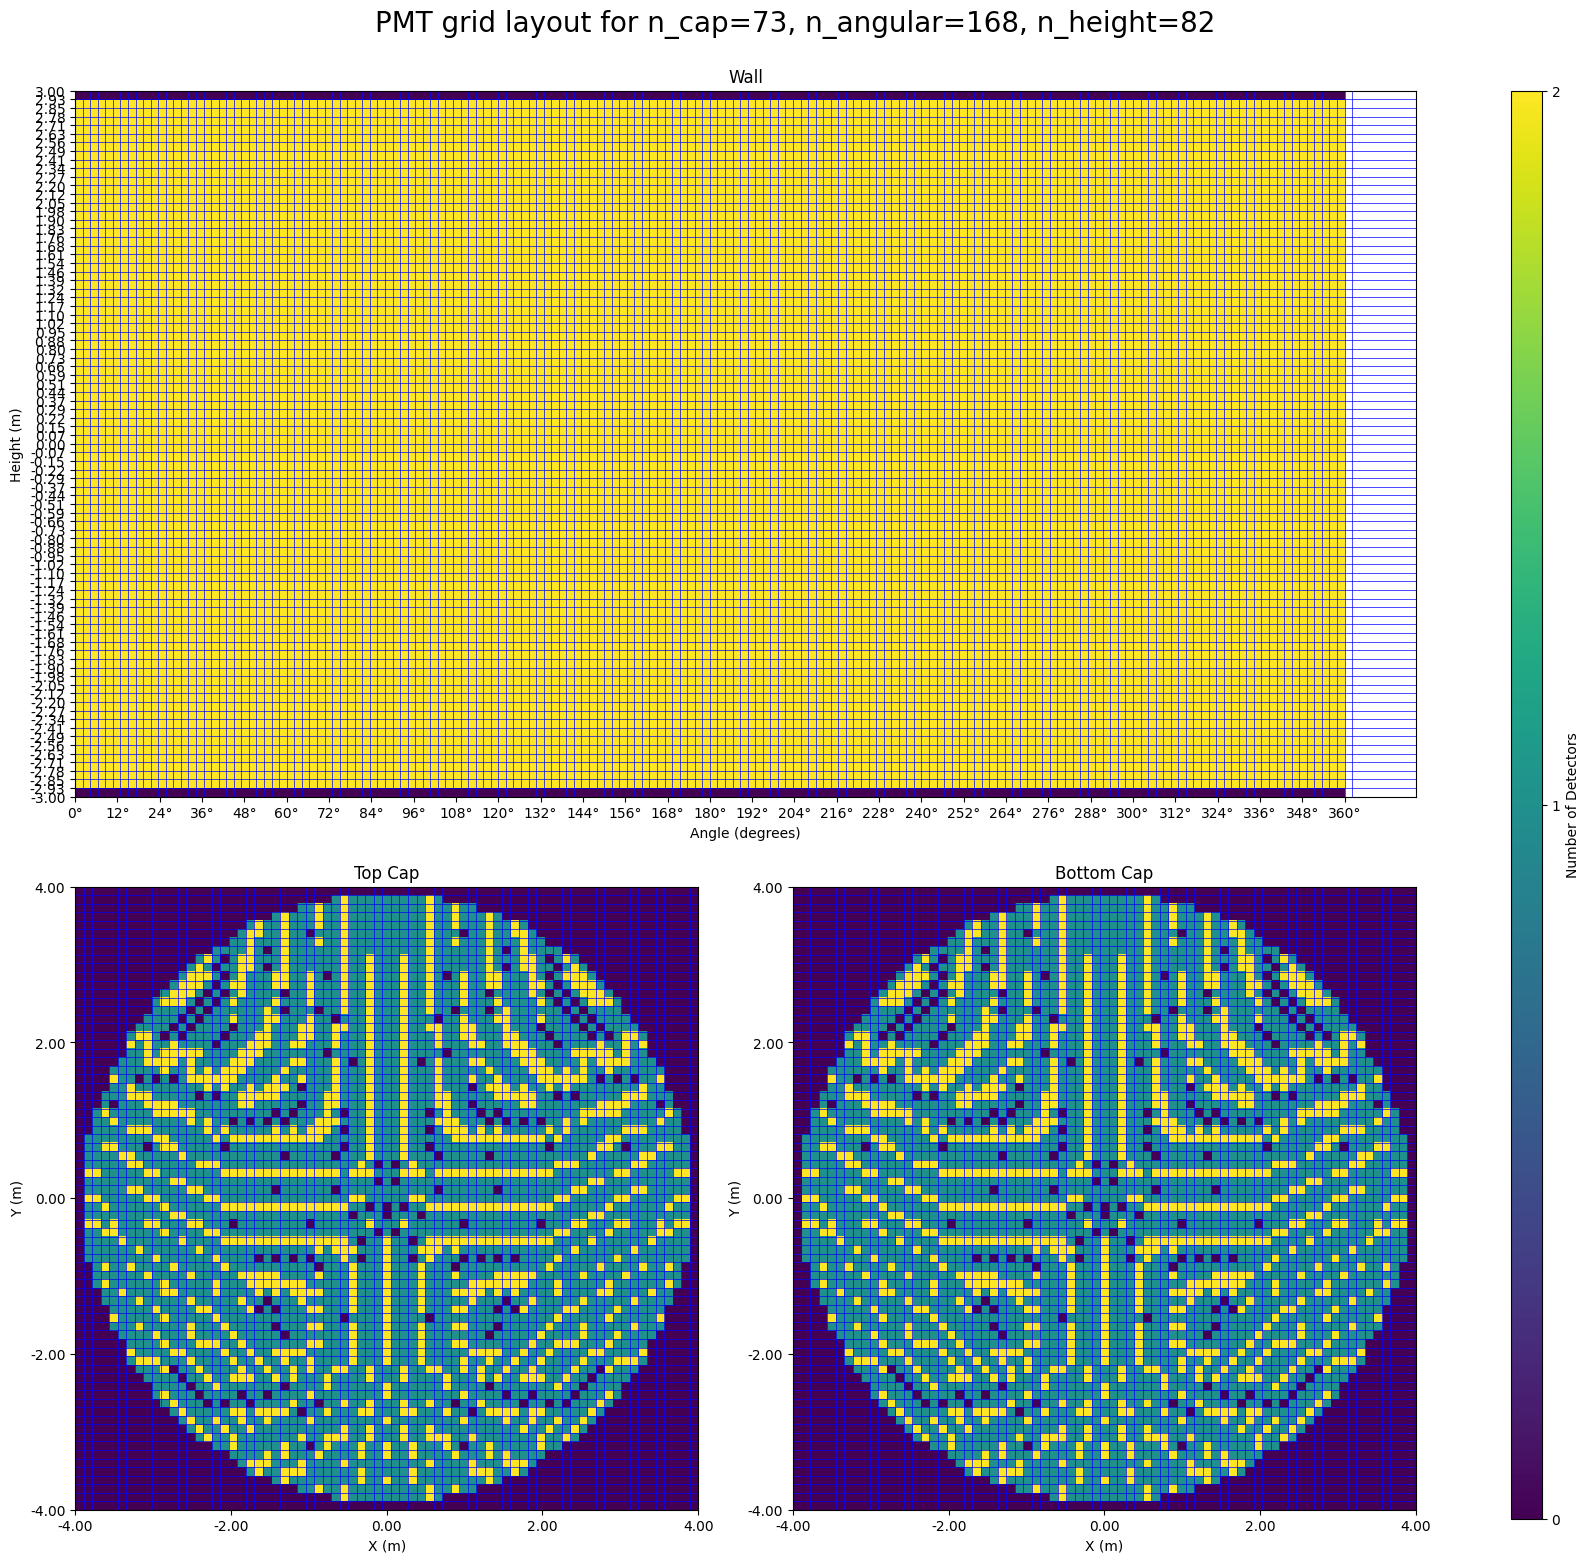

Red detectors: 1
Gray detectors: 1612


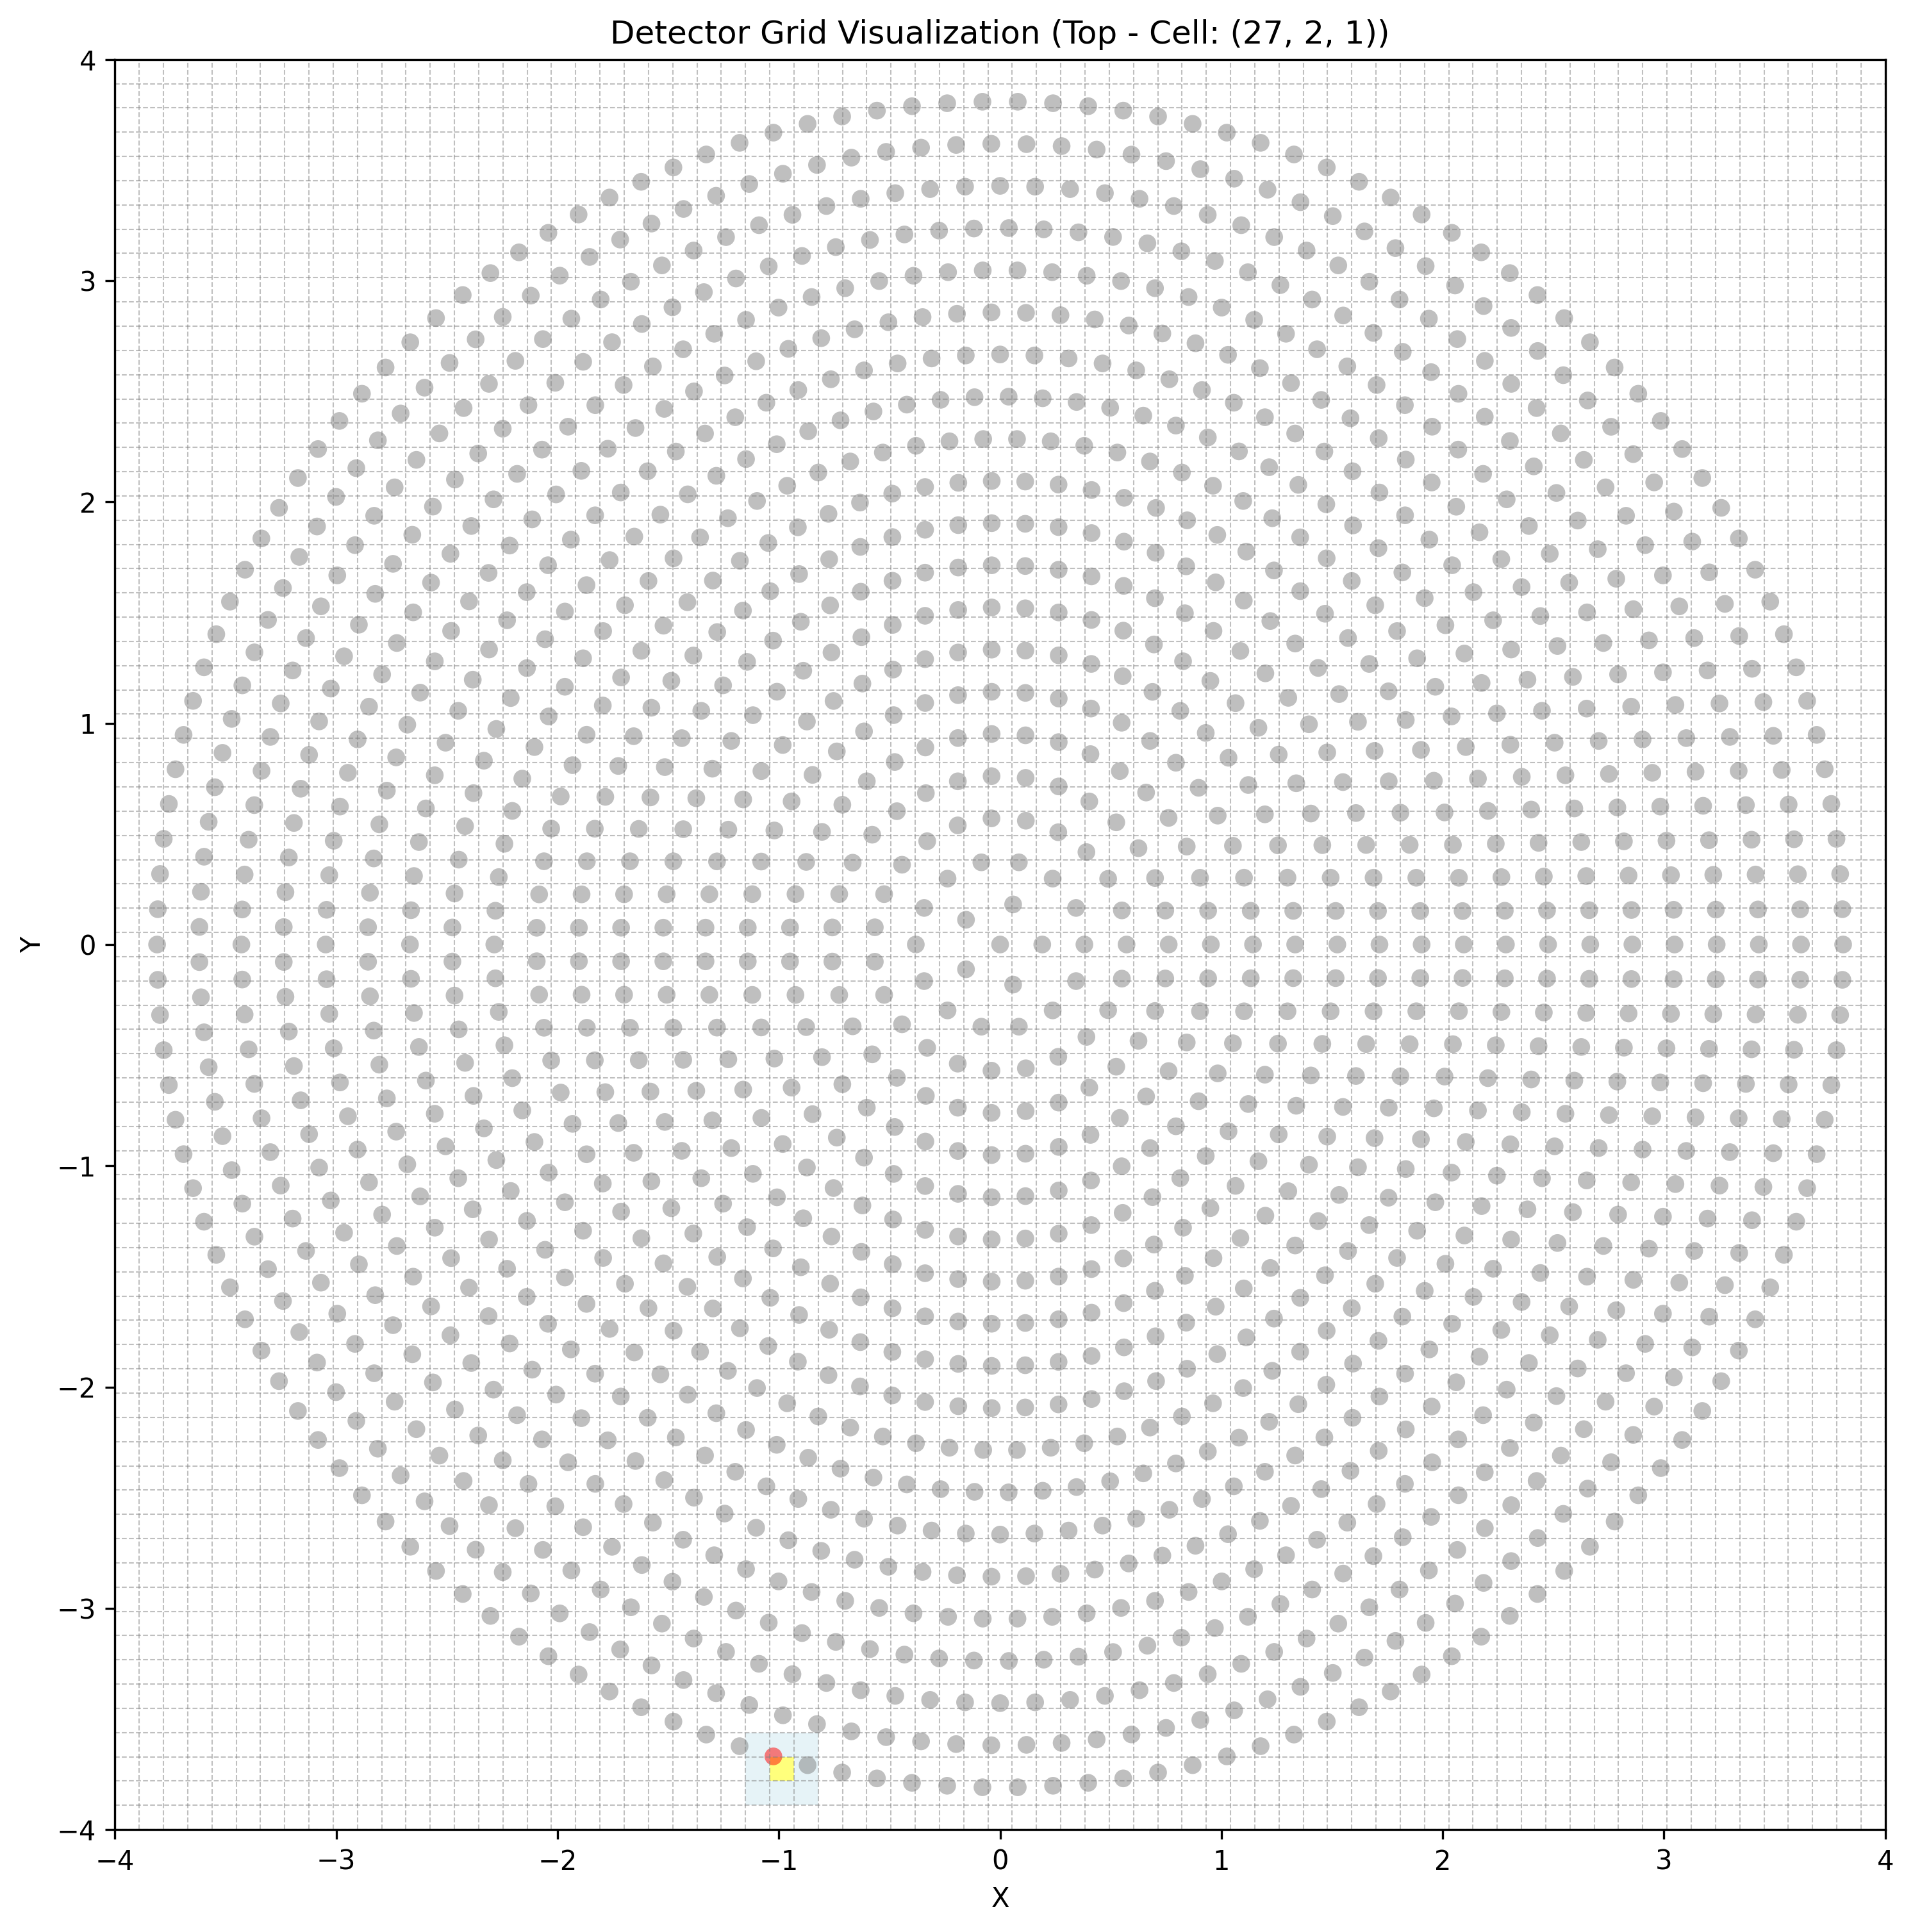

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib.collections import PatchCollection
import jax.numpy as jnp

def visualize_detector_grid(assignments, detector_points, detector_radius, r, h, n_cap, n_angular, n_height, dpi=300):
    def get_adjacent_cells(cell):
        i, j, k = cell
        if k == 0:  # Wall
            return [((i + di) % n_angular, (j + dj) % n_height, 0) for di in [-1, 0, 1] for dj in [-1, 0, 1]]
        else:  # Cap
            return [((i + di) % n_cap, (j + dj) % n_cap, k) for di in [-1, 0, 1] for dj in [-1, 0, 1]]

    # Choose a random cell
    k = np.random.choice([0, 1, 2])  # 0: Wall, 1: Top cap, 2: Bottom cap
    i, j = np.random.randint(0, n_angular if k == 0 else n_cap), np.random.randint(0, n_height if k == 0 else n_cap)
    center_cell = (i, j, k)

    # Get adjacent cells
    cells_to_plot = [center_cell] + get_adjacent_cells(center_cell)

    # Set up the plot
    if k == 0:  # Wall
        circumference = 2 * np.pi * r
        aspect_ratio = circumference / h
        fig_width = min(20, max(10, 8 * aspect_ratio))  # Cap width between 10 and 20
        fig_height = fig_width / aspect_ratio
        fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
        ax.set_xlim(0, circumference)
        ax.set_ylim(-h/2, h/2)
        
        # Draw grid lines
        ax.vlines(np.linspace(0, circumference, n_angular+1), -h/2, h/2, colors='gray', linestyles='--', alpha=0.5, linewidth=0.5)
        ax.hlines(np.linspace(-h/2, h/2, n_height+1), 0, circumference, colors='gray', linestyles='--', alpha=0.5, linewidth=0.5)
        
        # Shade cells
        cell_width, cell_height = circumference / n_angular, h / n_height
        rects = [Rectangle((cell[0] * cell_width, -h/2 + cell[1] * cell_height), 
                           cell_width, cell_height) for cell in cells_to_plot]
    else:  # Cap
        fig, ax = plt.subplots(figsize=(10, 10), dpi=dpi)
        ax.set_xlim(-r, r)
        ax.set_ylim(-r, r)
        
        # Draw grid lines
        grid_lines = np.linspace(-r, r, n_cap + 1)
        ax.vlines(grid_lines, -r, r, colors='gray', linestyles='--', alpha=0.5, linewidth=0.5)
        ax.hlines(grid_lines, -r, r, colors='gray', linestyles='--', alpha=0.5, linewidth=0.5)
        
        # Shade cells
        cell_size = 2 * r / n_cap
        rects = [Rectangle((-r + cell[0] * cell_size, -r + cell[1] * cell_size), 
                           cell_size, cell_size) for cell in cells_to_plot]

    # Add shaded cells to plot
    pc = PatchCollection(rects, facecolors=['yellow' if cell == center_cell else 'lightblue' for cell in cells_to_plot], 
                         edgecolors='none', alpha=0.3)
    ax.add_collection(pc)

    # Prepare detector data
    detector_points = np.array(detector_points)
    if k == 0:  # Wall
        on_surface = np.abs(np.sqrt(detector_points[:, 0]**2 + detector_points[:, 1]**2) - r) <= detector_radius
        x = np.arctan2(detector_points[on_surface, 1], detector_points[on_surface, 0]) % (2 * np.pi) * r
        y = detector_points[on_surface, 2]
    else:  # Cap
        on_surface = (k == 1) & (detector_points[:, 2] > h/2 - detector_radius) | (k == 2) & (detector_points[:, 2] < -h/2 + detector_radius)
        x, y = detector_points[on_surface, 0], detector_points[on_surface, 1]

    # Determine detector colors
    detector_cells = assignments[on_surface]
    colors = ['red' if any(tuple(cell) == center_cell for cell in detector if not np.all(cell == -1)) else 'gray' for detector in detector_cells]

    # Plot detectors
    circles = [Circle((xi, yi), detector_radius) for xi, yi in zip(x, y)]
    pc = PatchCollection(circles, facecolors=colors, alpha=0.5, edgecolors='none')
    ax.add_collection(pc)

    print(f"Red detectors: {colors.count('red')}")
    print(f"Gray detectors: {colors.count('gray')}")

    # Set labels and title
    ax.set_xlabel("Distance along wall" if k == 0 else "X")
    ax.set_ylabel("Height" if k == 0 else "Y")
    if k != 0:
        ax.set_aspect("equal")
    else:
        ax.set_aspect("auto")
    
    plt.tight_layout()  # Adjust the layout to prevent clipping

    cap_type = "Top" if k == 1 else "Bottom" if k == 2 else "Wall"
    ax.set_title(f"Detector Grid Visualization ({cap_type} - Cell: {center_cell})")

    plt.show()

# Example usage
r, h = 4.0, 6.0
n_cap, n_angular, n_height = 73, 168, 82

assignments = assign_detectors_to_grid(detector_points, detector_radius, r, h, n_cap, n_angular, n_height)
detector_grid_map = create_detector_grid_map(assignments, n_cap, n_angular, n_height)

# Assuming you have detector_grid_map from previous computations
plot_detector_grid(detector_grid_map, r, h, n_cap, n_angular, n_height)

# Example usage:
visualize_detector_grid(assignments, detector_points, detector_radius, r, h, n_cap, n_angular, n_height)

Geometric intersections: 1
Additional distance-based candidates: 7
Final assigned detectors: 8
  - From geometric: 1
  - Added from distance: 7


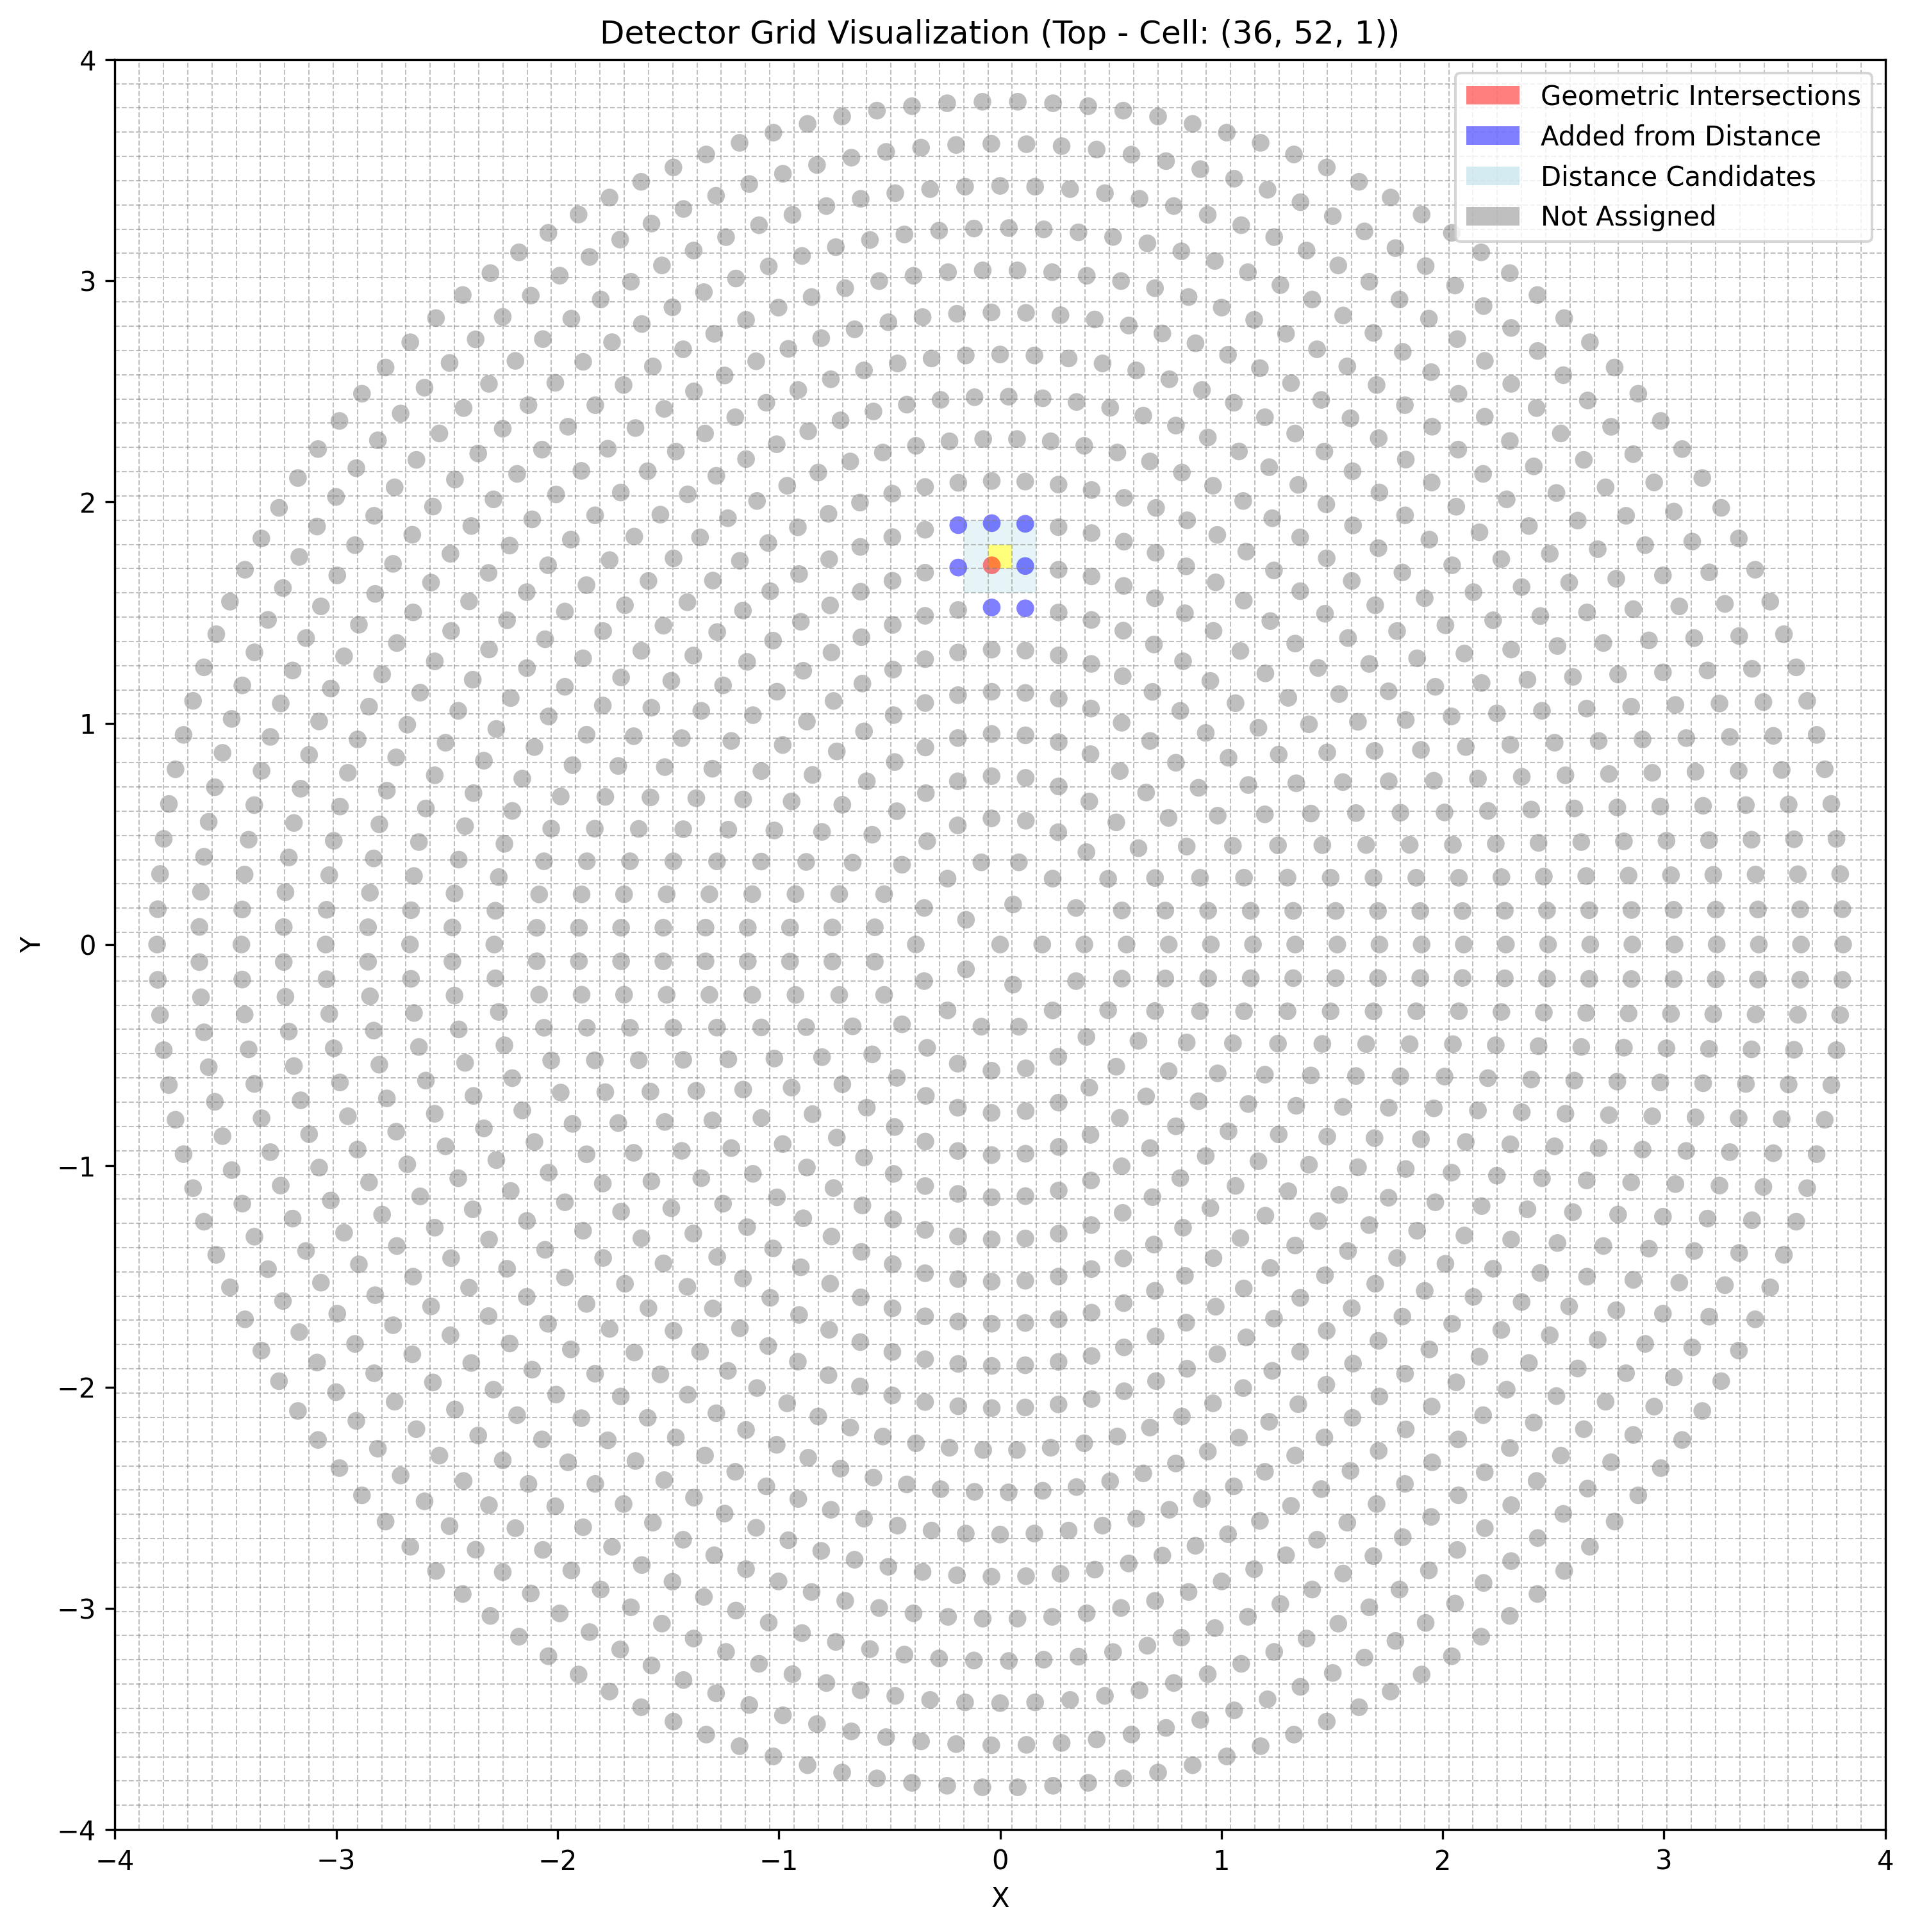

In [8]:
def calculate_min_distance(positions):
    distances = pdist(positions)
    return np.min(distances) if len(distances) > 0 else 1.0

def visualize_detector_grid_new(assignments_geometric, assignments_distance, inverted_detector_map,
                              detector_points, detector_radius, r, h, n_cap, n_angular, n_height, dpi=300):
    """
    Visualize detector grid with both geometric and distance-based assignments
    """
    # Convert JAX arrays to NumPy
    assignments_geometric = np.array(assignments_geometric)
    assignments_distance = np.array(assignments_distance)
    inverted_detector_map = np.array(inverted_detector_map)
    detector_points = np.array(detector_points)

    def get_adjacent_cells(cell):
        i, j, k = cell
        if k == 0:  # Wall
            return [((i + di) % n_angular, (j + dj) % n_height, 0)
                   for di in [-1, 0, 1] for dj in [-1, 0, 1]]
        else:  # Cap
            return [((i + di) % n_cap, (j + dj) % n_cap, k)
                   for di in [-1, 0, 1] for dj in [-1, 0, 1]]

    # Choose a random cell
    k = np.random.choice([0, 1, 2])
    i, j = np.random.randint(0, n_angular if k == 0 else n_cap), np.random.randint(0, n_height if k == 0 else n_cap)
    center_cell = (i, j, k)

    # Get adjacent cells
    cells_to_plot = [center_cell] + get_adjacent_cells(center_cell)

    # Calculate cell index for inverted map
    def get_cell_index(cell):
        i, j, k = cell
        if k == 0:
            return i * n_height + j  # Wall indexing
        else:
            return (n_angular * n_height +  # Base offset for caps
                   (k - 1) * n_cap * n_cap +  # Offset for bottom cap
                   i * n_cap + j)  # Cap cell indexing

    # Get center cell index
    center_idx = get_cell_index(center_cell)

    # Get geometric intersections
    geometric_detectors = set()
    for det_idx, det_assignments in enumerate(assignments_geometric):
        # Unpack center cell
        ci, cj, ck = center_cell
        # Check if any assignment matches our cell coordinates
        if np.any((det_assignments[:, 0] == ci) &
                  (det_assignments[:, 1] == cj) &
                  (det_assignments[:, 2] == ck)):
            geometric_detectors.add(det_idx)

    # Get distance-based assignments for this cell
    distance_detectors = set(int(idx) for idx in assignments_distance[center_idx])

    # Get actual assigned detectors from inverted map
    final_detectors = set(int(idx) for idx in inverted_detector_map[center_idx][inverted_detector_map[center_idx] != -1])

    # Calculate distance-only detectors (those that weren't geometric)
    distance_only_detectors = distance_detectors - geometric_detectors

    # Set up the plot
    if k == 0:  # Wall
        circumference = 2 * np.pi * r
        aspect_ratio = circumference / h
        fig_width = min(20, max(10, 8 * aspect_ratio))
        fig_height = fig_width / aspect_ratio
        fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
        ax.set_xlim(0, circumference)
        ax.set_ylim(-h/2, h/2)

        # Draw grid
        ax.vlines(np.linspace(0, circumference, n_angular+1), -h/2, h/2,
                 colors='gray', linestyles='--', alpha=0.5, linewidth=0.5)
        ax.hlines(np.linspace(-h/2, h/2, n_height+1), 0, circumference,
                 colors='gray', linestyles='--', alpha=0.5, linewidth=0.5)

        # Shade cells
        cell_width, cell_height = circumference / n_angular, h / n_height
        rects = [Rectangle((cell[0] * cell_width, -h/2 + cell[1] * cell_height),
                          cell_width, cell_height) for cell in cells_to_plot]

        # Transform detector coordinates
        on_surface = np.abs(np.sqrt(detector_points[:, 0]**2 + detector_points[:, 1]**2) - r) <= detector_radius
        x = np.arctan2(detector_points[on_surface, 1], detector_points[on_surface, 0]) % (2 * np.pi) * r
        y = detector_points[on_surface, 2]

    else:  # Cap
        fig, ax = plt.subplots(figsize=(10, 10), dpi=dpi)
        ax.set_xlim(-r, r)
        ax.set_ylim(-r, r)

        # Draw grid
        grid_lines = np.linspace(-r, r, n_cap + 1)
        ax.vlines(grid_lines, -r, r, colors='gray', linestyles='--', alpha=0.5, linewidth=0.5)
        ax.hlines(grid_lines, -r, r, colors='gray', linestyles='--', alpha=0.5, linewidth=0.5)

        # Shade cells
        cell_size = 2 * r / n_cap
        rects = [Rectangle((-r + cell[0] * cell_size, -r + cell[1] * cell_size),
                          cell_size, cell_size) for cell in cells_to_plot]

        # Transform detector coordinates
        on_surface = ((k == 1) & (detector_points[:, 2] > h/2 - detector_radius) |
                     (k == 2) & (detector_points[:, 2] < -h/2 + detector_radius))
        x, y = detector_points[on_surface, 0], detector_points[on_surface, 1]

    # Add shaded cells
    pc = PatchCollection(rects,
                        facecolors=['yellow' if cell == center_cell else 'lightblue'
                                  for cell in cells_to_plot],
                        edgecolors='none', alpha=0.3)
    ax.add_collection(pc)

    # Create circles for detectors
    circles = []
    colors = []

    for idx, (xi, yi) in enumerate(zip(x, y)):
        circle = Circle((xi, yi), detector_radius)
        circles.append(circle)

        det_idx = np.where(on_surface)[0][idx]
        if det_idx in geometric_detectors:
            colors.append('red')  # All geometric intersections (even if also in distance)
        elif det_idx in distance_only_detectors and det_idx in final_detectors:
            colors.append('blue')  # Distance-based assignments that made it (and weren't geometric)
        elif det_idx in distance_only_detectors:
            colors.append('lightblue')  # Distance-based candidates not used (and weren't geometric)
        else:
            colors.append('gray')  # Not assigned to this cell

    pc = PatchCollection(circles, facecolors=colors, alpha=0.5, edgecolors='none')
    ax.add_collection(pc)

    # Print statistics
    print(f"Geometric intersections: {len(geometric_detectors)}")
    print(f"Additional distance-based candidates: {len(distance_only_detectors)}")
    print(f"Final assigned detectors: {len(final_detectors)}")
    print(f"  - From geometric: {len(geometric_detectors)}")
    print(f"  - Added from distance: {len(final_detectors - geometric_detectors)}")

    # Set labels and title
    ax.set_xlabel("Distance along wall" if k == 0 else "X")
    ax.set_ylabel("Height" if k == 0 else "Y")
    if k != 0:
        ax.set_aspect("equal")
    else:
        ax.set_aspect("auto")

    plt.tight_layout()

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', alpha=0.5, label='Geometric Intersections'),
        Patch(facecolor='blue', alpha=0.5, label='Added from Distance'),
        Patch(facecolor='lightblue', alpha=0.5, label='Distance Candidates'),
        Patch(facecolor='gray', alpha=0.5, label='Not Assigned')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    cap_type = "Top" if k == 1 else "Bottom" if k == 2 else "Wall"
    ax.set_title(f"Detector Grid Visualization ({cap_type} - Cell: {center_cell})")
    plt.show()

# Example usage - this is how it should be setup
r, h = 4.0, 6.0
n_cap, n_angular, n_height = 73, 168, 82
max_detectors_per_cell = 8

# Step 1: Get geometric assignments
assignments_geometric = assign_detectors_to_grid(
    detector_points, detector_radius, r, h, n_cap, n_angular, n_height)

# Step 2: Get grid centers and distance-based assignments
grid_centers = calculate_grid_centers(r, h, n_cap, n_angular, n_height)
assignments_distance = find_closest_detectors(
    grid_centers,
    detector_points,
    max_detectors_per_cell
)

# Step 3: Create inverted detector map with BOTH assignments
inverted_detector_map = create_inverted_detector_map(
    assignments_geometric,
    assignments_distance,  # Make sure this is passed
    n_cap, n_angular, n_height,
    max_detectors_per_cell,
    detector_points.shape[0]
)

# Example usage:
visualize_detector_grid_new(
    assignments_geometric, assignments_distance, inverted_detector_map,
    detector_points, detector_radius, r, h, n_cap, n_angular, n_height
)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from scipy.spatial.distance import pdist

def display_detector_grid(detector_positions, detector_cases, assignments_geometric, assignments_distance,
                        inverted_detector_map, selected_cell, n_cap, n_angular, n_height,
                        cyl_radius, cyl_height, file_name=None):
    """
    Display detector visualization with grid cell highlighting and detector assignments.
    Using original coordinate transformations.
    """
    n_detectors = len(detector_positions)
    x = np.zeros(n_detectors)
    y = np.zeros(n_detectors)
    
    # Use original transformation parameters
    corr = cyl_radius / cyl_height
    caps_offset = -0.1
    
    # Transform detector positions using original transformations
    # Barrel case (0)
    barrel_mask = detector_cases == 0
    theta = np.arctan2(detector_positions[barrel_mask, 1], detector_positions[barrel_mask, 0])
    theta = (theta + np.pi * 3 / 2) % (2 * np.pi) / 2
    x[barrel_mask] = theta
    y[barrel_mask] = detector_positions[barrel_mask, 2] / cyl_height
    
    # Top cap case (1)
    top_mask = detector_cases == 1
    x[top_mask] = corr * detector_positions[top_mask, 0] / cyl_height + np.pi / 2
    y[top_mask] = 1 + corr * (caps_offset + detector_positions[top_mask, 1] / cyl_height)
    
    # Bottom cap case (2)
    bottom_mask = detector_cases == 2
    x[bottom_mask] = corr * detector_positions[bottom_mask, 0] / cyl_height + np.pi / 2
    y[bottom_mask] = -1 + corr * (-caps_offset - detector_positions[bottom_mask, 1] / cyl_height)
    
    # Get selected cell index and assignments
    i, j, k = selected_cell
    center_idx = (i * n_height + j) if k == 0 else (
        n_angular * n_height + (k-1) * n_cap * n_cap + i * n_cap + j
    )
    
    # Get detector assignments for selected cell
    geometric_detectors = set()
    for det_idx, det_assignments in enumerate(assignments_geometric):
        if np.any((det_assignments[:, 0] == i) &
                  (det_assignments[:, 1] == j) &
                  (det_assignments[:, 2] == k)):
            geometric_detectors.add(det_idx)
    
    distance_detectors = set(int(idx) for idx in assignments_distance[center_idx])
    final_detectors = set(int(idx) for idx in inverted_detector_map[center_idx][inverted_detector_map[center_idx] != -1])
    distance_only_detectors = distance_detectors - geometric_detectors
    
    # Calculate dimensions using original method
    transformed_positions = np.column_stack((x, y))
    min_distance = np.min(pdist(transformed_positions)) if len(transformed_positions) > 1 else 1.0
    circle_diameter = min_distance
    
    # Calculate exact dimensions needed
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    
    # Add padding
    padding = circle_diameter
    x_min -= padding
    x_max += padding
    y_min -= padding
    y_max += padding
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    # Set figure size based on data range
    fig_width = 12
    fig_height = fig_width * (y_range / x_range)
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor='black')

    
    # Create detector colors array
    colors = np.full((n_detectors, 4), [0.5, 0.5, 0.5, 0.5])  # Default gray
    colors[list(geometric_detectors)] = [1, 0, 0, 0.8]  # Red for geometric
    colors[list(distance_only_detectors & final_detectors)] = [0, 0, 1, 0.8]  # Blue for distance
    
    # Create EllipseCollection
    ells = EllipseCollection(widths=circle_diameter, heights=circle_diameter,
                            angles=0, units='x',
                            facecolors=colors,
                            offsets=transformed_positions,
                            transOffset=ax.transData)
    
    ax.add_collection(ells)
    
    # Set plot appearance
    ax.set_facecolor("black")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', alpha=0.8, label='Geometric Intersection'),
        Patch(facecolor='blue', alpha=0.8, label='Distance Assignment')
    ]
    ax.legend(handles=legend_elements, loc='upper right',
             facecolor='black', edgecolor='white')
    for text in ax.get_legend().get_texts():
        text.set_color('white')
    
    plt.tight_layout()
    
    if file_name:
        plt.savefig(file_name, bbox_inches='tight', pad_inches=0.1,
                   facecolor='black', edgecolor='none')
    plt.show()
    
    # Print statistics
    print(f"Selected cell: ({i}, {j}, {k})")
    print(f"Geometric intersections: {len(geometric_detectors)}")
    print(f"Additional distance-based assignments: {len(distance_only_detectors & final_detectors)}")
    print(f"Total assigned detectors: {len(final_detectors)}")

def select_random_cell(n_cap, n_angular, n_height):
    """
    Randomly select a grid cell.
    """
    k = np.random.choice([0, 1, 2])
    if k == 0:  # Barrel
        i = np.random.randint(0, n_angular)
        j = np.random.randint(0, n_height)
    else:  # Caps
        i = np.random.randint(0, n_cap)
        j = np.random.randint(0, n_cap)
    return (i, j, k)

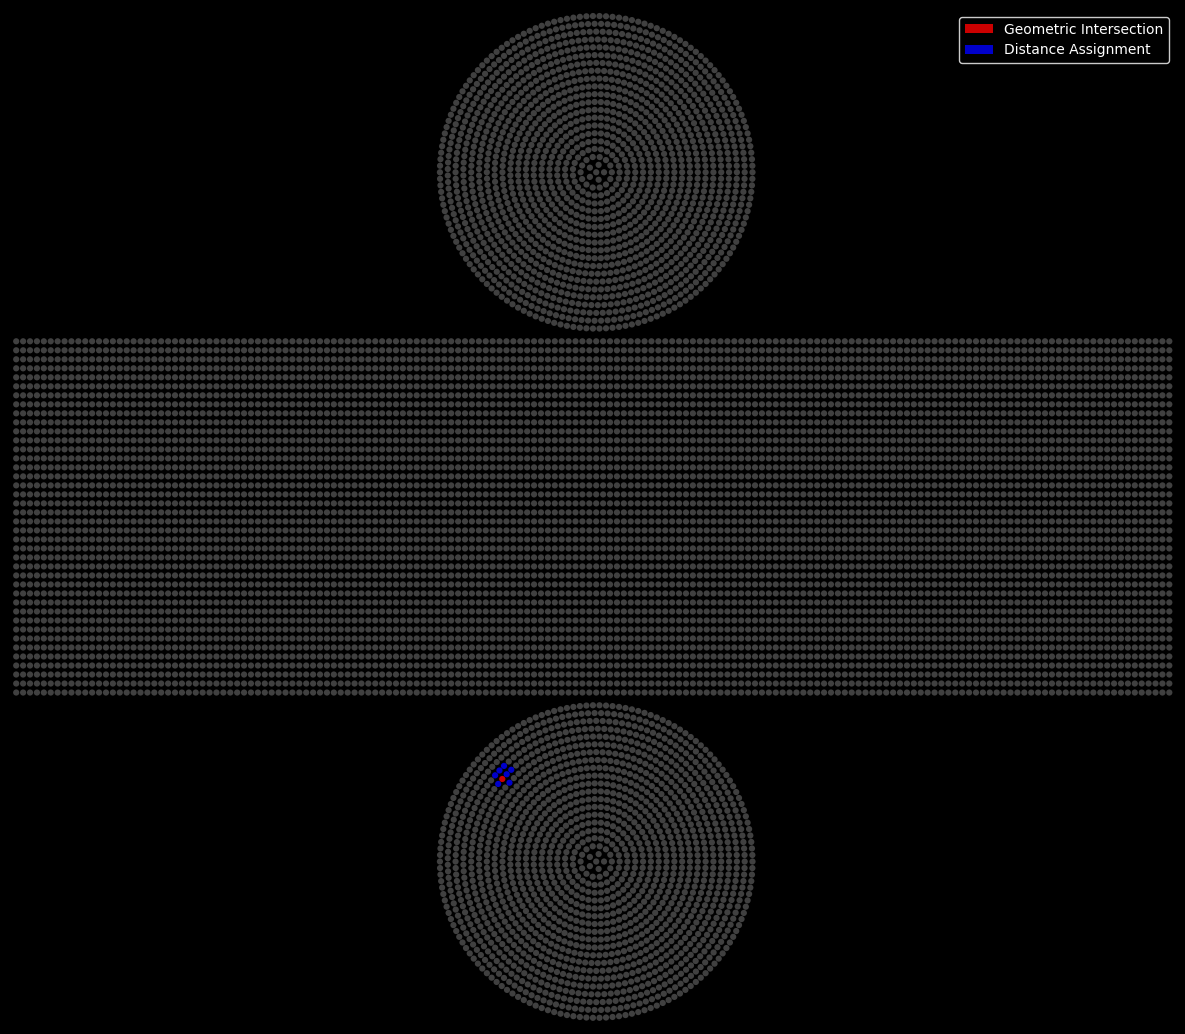

Selected cell: (15, 17, 2)
Geometric intersections: 1
Additional distance-based assignments: 7
Total assigned detectors: 8


In [35]:
# usage

# Setup parameters
r, h = 4.0, 6.0

# Number of grid cells
n_cap, n_angular, n_height = 73, 168, 82

# Maximum number of detectors per cell
max_detectors_per_cell = 8

# Get geometric assignments
assignments_geometric = assign_detectors_to_grid(
    detector_points, detector_radius, r, h, n_cap, n_angular, n_height)

# Get distance-based assignments
grid_centers = calculate_grid_centers(r, h, n_cap, n_angular, n_height)

assignments_distance = find_closest_detectors(
    grid_centers, 
    detector_points, 
    max_detectors_per_cell
)

# Create inverted detector map
inverted_detector_map = create_inverted_detector_map(
    assignments_geometric,
    assignments_distance,
    n_cap, n_angular, n_height,
    max_detectors_per_cell,
    detector_points.shape[0]
)

# Visualize
# get random cell
selected_cell = select_random_cell(n_cap, n_angular, n_height)

display_detector_grid(
    detector_positions=detector_points,
    detector_cases=detector_cases,
    assignments_geometric=assignments_geometric,
    assignments_distance=assignments_distance,
    inverted_detector_map=inverted_detector_map,
    selected_cell=selected_cell,
    n_cap=n_cap,
    n_angular=n_angular,
    n_height=n_height,
    cyl_radius=r,
    cyl_height=h
)